In [1]:
!pwd ## checkout if we are working under the correct directory

/Users/tiany4/Documents/00_mom_stuff/LungCancer


In [2]:
import numpy as np

In [3]:
import networkx as nx
import pandas as pd
from pathlib import Path
from build_graph import build_graph_from_raw
from data import GNNDataset,nx_to_tg_graph,process_feature,GNNgraphSampler
from models import GNN_pred

## Generate nx Graphs from raw data

In [4]:
ls

1-s2.0-S2667237522002363-main.pdf  data-exploration.ipynb
LICENSE                            data.py
README.md                          main_pipline.ipynb
__pycache__/                       models.py
build_graph.py                     test.py
data/                              utils.py


In [5]:
# directory names
graph_dir = "data/graphs_from_raw"

In [6]:
import os
from pathlib import Path
from build_graph import build_graph_from_raw  # the module to create a networkx graph
import networkx as nx

In [7]:
df = pd.read_csv('data/features_withloc.csv')

In [8]:
unique_spots = np.unique(df.spot)

In [9]:
unique_spots

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

In [11]:
# # generate nx graphs from raw data
# for spot in unique_spots:
    
#     df_temp = df[df.spot==spot]
#     G = build_graph_from_raw(df_temp)
    
#     file_path = Path(graph_dir, 'spot'+str(spot)+'.gpkl')
#         # nodes with distance less than max_dist is considered as connected
#     nx.write_gpickle(G, file_path)

In [14]:
# check out file names
for file in os.listdir(graph_dir)[:3]:
    if not file.endswith('.DS_Store'):
        print(file)
        file_path = Path(graph_dir, file)
        G = nx.read_gpickle(file_path)
        print(G.nodes()[0])

spot1.gpkl
{'histology': [1], 'coord': array([876., 583.]), 'marker': array([1696.1357 ,  195.96324])}
spot6.gpkl
{'histology': [1], 'coord': array([3461.,  811.]), 'marker': array([492.04843, 239.0114 ])}


In [15]:
# checkout node features. NOTE: to add more features, please modify the build_graph.py module. 
G.nodes()[0]

{'histology': [1],
 'coord': array([3461.,  811.]),
 'marker': array([492.04843, 239.0114 ])}

In [16]:
# G.edges()

In [17]:
# checkout edge features: node pair distance and encoded edge_type, 1 means far, 0 means close 
# for details, please checkout build_graph.py
# G.edges()[(4,108)]

In [18]:
# node_features=["marker", "coord"],
# edge_features=["edge_type", "distance"],

## Generate tensor graphs from nx graphs

In [19]:
# from data import GNNDataset,nx_to_tg_graph,process_feature,GNNgraphSampler
from data import nx_to_tg_graph,GNNDataset,GNNgraphSampler
import torch

In [20]:
tensor_dir = 'data/tensor_graphs'

In [22]:
# # generate nx graphs from raw data

# for file in os.listdir(graph_dir):
    
#     if not file.endswith('.DS_Store'):
#         graph_path = os.path.join(graph_dir, file)
#         G = nx.read_gpickle(graph_path)
#         data = nx_to_tg_graph(G)
#         torch.save(data, os.path.join(tensor_dir,'%s.gpt' % file[:-5]))


In [24]:
# check out file names
for file in os.listdir(tensor_dir)[0:3]:
    print(file)
#     file_path = Path(tensor_dir, file)
#     data = torch.load(file_path)

.gpt
.DS_Store
spot3.gpt


In [25]:
data = torch.load('data/tensor_graphs/spot3.gpt')

In [26]:
# checkout tensor data which is standard input for GNN  ( x contains node features, y contains nodel label).
# for details/modification, please checkout the data.py module.
data.keys

['edge_attr', 'y', 'edge_index', 'x', 'num_nodes']

In [27]:
data['y'].shape

torch.Size([4724])

## Customized standard torch.geometric dataset and dataloader

In [28]:
from data import GNNDataset,GNNgraphSampler
from utils import CHANNEL_MARKERS

In [38]:
from utils import CHANNEL_MARKERS
dataset = GNNDataset(root="data",  
                     node_features=[ 'histology','marker', 'coord'],
                     edge_features=['edge_type', 'distance'],
                     channel_markers=CHANNEL_MARKERS)

In [39]:
dataset.channel_markers  ## channels used for test

['DAPI_mean', 'PDGFRB_mean']

In [40]:
dataset.node_feature_names 

['histology', 'marker-DAPI_mean', 'marker-PDGFRB_mean', 'coord-x', 'coord-y']

In [41]:
dataset.edge_feature_names

['edge_type', 'distance']

In [78]:
# customized dataloader
data_iter = GNNgraphSampler(dataset, 
                                 selected_inds=None,
                                     batch_size=2,
                                     num_graphs_per_segment=2,
                                     steps_per_segment=1000)

batch = next(data_iter)

Initiate data loader, subgraph source: None
1
['data/tensor_graphs/.gpt', 'data/tensor_graphs/spot1.gpt', 'data/tensor_graphs/spot10.gpt', 'data/tensor_graphs/spot2.gpt', 'data/tensor_graphs/spot3.gpt', 'data/tensor_graphs/spot4.gpt', 'data/tensor_graphs/spot5.gpt', 'data/tensor_graphs/spot6.gpt', 'data/tensor_graphs/spot7.gpt', 'data/tensor_graphs/spot8.gpt', 'data/tensor_graphs/spot9.gpt']
['data/tensor_graphs/.gpt', 'data/tensor_graphs/spot1.gpt', 'data/tensor_graphs/spot10.gpt', 'data/tensor_graphs/spot2.gpt', 'data/tensor_graphs/spot3.gpt', 'data/tensor_graphs/spot4.gpt', 'data/tensor_graphs/spot5.gpt', 'data/tensor_graphs/spot6.gpt', 'data/tensor_graphs/spot7.gpt', 'data/tensor_graphs/spot8.gpt', 'data/tensor_graphs/spot9.gpt']
0


In [79]:
batch.keys

['edge_attr', 'y', 'ptr', 'edge_index', 'x', 'batch', 'num_nodes']

## Sanity check GNN model training

Train a GNN model to do histology prediction. The main objective is to obtain node embeddings.

In [80]:
from models import GNN_pred   ## The module where models are defined

In [81]:
 model_kwargs = {
        'num_layer': 3, 
        'num_node_type': None,
        'num_feat': dataset[0].x.shape[1],
        'emb_dim': 512, 
        'num_node_tasks': 1,
        'num_graph_tasks': 0, 
        'node_embedding_output': 'last', 
        'drop_ratio': 0.25, 
        'graph_pooling': "max", 
        'gnn_type': "gin",
    }

In [82]:
model = GNN_pred(**model_kwargs)

In [83]:
# checkout model structure: linear embedding layer -> 3 GINConv layers 
#                         -> batch norm layers -> MLP head(for channel markers prediction) 

# Note: linear embedding layer combines node embeddings and edge embeddings, i.e. both node features and edge features will be used as input to the model. for details/modifications, please checkout models.py module.   
model 

GNN_pred(
  (gnn): GNN(
    (feat_embedding): Linear(in_features=5, out_features=512, bias=True)
    (gnns): ModuleList(
      (0): GINConv()
      (1): GINConv()
      (2): GINConv()
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [84]:
import torch.nn as nn
node_task_criterion = nn.MSELoss() ## using MSE as loss

In [85]:
device ='cpu'
# training
num_iterations = 100
optimizer = torch.optim.Adam(model.parameters()) 
losses = []
for i_iter in range(int(num_iterations)):
    batch = next(data_iter)
    batch = batch.to(device)
    batch_pred = model(batch)[0] 
    batch_y = batch.y.float() 
    loss = node_task_criterion(batch_pred,batch_y)
    losses.append(loss.detach())

    loss.backward()
    optimizer.step()
    model.zero_grad()

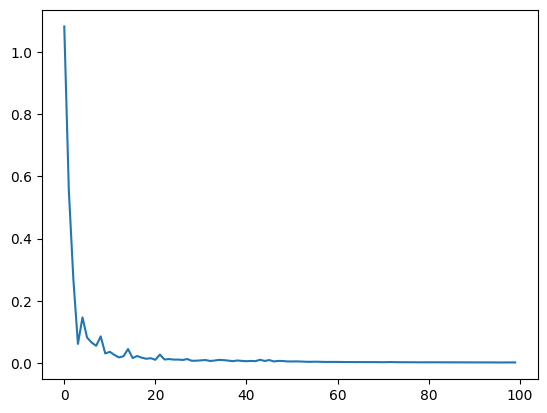

In [86]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [87]:
# By setting return_node_embedding=True, we can obtain node embeddings.
# This is an example for the first graph in the dataset.
embeddings = model(dataset[0],return_node_embedding=True)[1]
embeddings.shape

torch.Size([6871, 512])

For further node embedding clustering/analysis, maybe we can try the method described in https://www.biorxiv.org/content/10.1101/2022.05.12.491707v1.full.pdf page20